In [50]:
library(tidyverse)

options(
  readr.show_col_types = FALSE,
  readr.show_progress = FALSE,
  repr.plot.res = 200
)

theme_fakta <- theme_minimal() +
  theme(
    panel.grid.major.x = element_blank(),
    panel.grid.minor = element_blank(),
    plot.title = element_text(face = "bold", size = 18)
  )

theme_set(theme_fakta)

neighbour_colours <- c(
  "AT" = "#8da89a",
  "CZ" = "black",
  "DE" = "#ecb862",
  "PL" = "#e38474",
  "SK" = "#86a6d6"
)

neighbour_labels <- c(
  "AT" = "Rakousko",
  "CZ" = "Česko",
  "DE" = "Německo",
  "PL" = "Polsko",
  "SK" = "Slovensko"
)

scale_colour_region <- function(...) {
  scale_colour_manual(
    "Sousední země",
    values = neighbour_colours,
    na.value = "hotpink",
    labels = neighbour_labels,
    ...
  )
}

scale_fill_region <- function(...) {
  scale_fill_manual(
    "Sousední země",
    values = neighbour_colours,
    na.value = "hotpink",
    labels = neighbour_labels,
    ...
  )
}

scale_fill_source <- function(
    labels = c(
      "Coal" = "Uhlí",
      "Coal CHP" = "Uhelné teplárny",
      "Coal power" = "Uhelné elektrárny",
      "Gas" = "Zemní plyn",
      "NetImport" = "Import/export",
      "Nuclear" = "Jádro",
      "Renewables" = "OZE"
    ),
    ...) {
  scale_fill_manual(
    "",
    values = c(
      "Coal" = "#e15a77",
      "Coal CHP" = "#ed7e92",
      "Coal power" = "#e15a77",
      "Gas" = "#bb487f",
      "NetImport" = "#b8cfdb",
      "Nuclear" = "#8f9faf",
      "Renewables" = "#7fcfb6"
    ),
    labels = labels,
    ...
  )
}

scale_fill_coal_category <- function(...) {
  scale_fill_manual(
    "",
    values = c(
      "coal_chp" = "#ed7e92",
      "coal_power" = "#e15a77"
    ),
    labels = c(
      "coal_chp" = "Uhelné teplárny",
      "coal_power" = "Uhelné elektrárny"
    ),
    ...
  )
}

save_svg_data <- function(save_svgs, data, name, width, height) {
  if (!save_svgs) {
    return
  }

  data_path <- str_glue("{output_dir}/../figures/{name}.csv")
  svg_path <- str_glue("{output_dir}/../figures/{name}.svg")

  if (!is.null(data)) {
    data |>
      mutate(across(where(is.double), ~ round(.x, 3))) |>
      write_csv(data_path)
  }

  ggsave(svg_path, width = fig_width, height = fig_height, create.dir = TRUE)
}


## Parameters


In [17]:
mainline_weather_year <- 2009
subsidy_weather_year <- mainline_weather_year

# Save SVGs and data of the generated charts when running the notebook.
save_svgs <- TRUE

scenarios <- c(
  "2025-cheap-ets" = "Levnější povolenka",
  "2025-expensive-ets" = "Dražší povolenka",
  "2025-crit" = "Kritický 25",
  "2028-slow" = "Pomalejší rozvoj",
  "2028-advanced" = "Rychlejší rozvoj",
  "2028-crit" = "Kritický",
  "2028-supercrit" = "Superkritický"
)

fix_scenario_names <- function(.data) {
  mutate(
    .data,
    name = factor(name, levels = names(scenarios), labels = scenarios)
  )
}

analysis_name <- str_glue("coaldown+weather-{mainline_weather_year}")
capex_analysis_name <- str_glue("coaldown+weather-1985+capex")
output_dir <- "../publication/model-runs"

df_capex_stats <- str_glue("{output_dir}/{capex_analysis_name}/{capex_analysis_name}-complete.csv") |>
  read_csv() |>
  select(!1) |>
  filter(
    # Skip the all-region aggregate.
    !str_detect(region, ", "),
    season == "Y",
    # Skip the supercritical scenario for mainstream analyses.
    name != "2028-supercrit",
    name != "2028-no"
  ) |>
  fix_scenario_names()

df_all_years_stats <- str_glue("{output_dir}/coaldown+weather-????/*-complete.csv") |>
  Sys.glob() |>
  map(
    ~ read_csv(.x, show_col_types = FALSE) |>
      select(!1) |>
      mutate(year = str_extract(.x, "(?<=weather-)[0-9]+") |> as.integer())
  ) |>
  list_rbind() |>
  filter(
    # Skip the all-region aggregate.
    !str_detect(region, ", "),
    season == "Y",
    name != "2028-no"
  ) |>
  fix_scenario_names()

df_all_years_demand <- df_all_years_stats |>
  filter(stat == "load_TWh") |>
  select(name, region, demand_TWh = val) |>
  summarise(
    demand_TWh = mean(demand_TWh),
    .by = c(name, region)
  )


New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`


## Summaries of sources – installed capacities, production, etc.


In [18]:
df_import_totals <- df_all_years_stats |>
  filter(
    name %in% scenarios,
    source == "TOTAL",
    stat %in% c("export_TWh", "import_TWh", "load_TWh", "net_import_TWh")
  ) |>
  summarise(
    val = mean(val),
    .by = c(name, region, source, stat)
  ) |>
  pivot_wider(id_cols = c("name", "region"), names_from = "stat", values_from = "val") |>
  mutate(is_importing = net_import_TWh > 0) |>
  pivot_longer(!c(name:region, is_importing), names_to = "stat", values_to = "val") |>
  mutate(
    name = factor(name, scenarios),
    region = factor(region),
    country_name = countrycode::countrycode(region, origin = "iso2c", destination = "cldr.name.cs")
  )

df_production <- df_all_years_stats |>
  filter(
    region == "CZ",
    stat == "production_TWh",
    !(source %in% c("TOTAL", "dsr", "eens", "heat", "li", "pump", "pump_open"))
  ) |>
  summarise(
    val = mean(val),
    .by = c(name, region, source, stat)
  ) |>
  mutate(
    source_group = case_when(
      str_detect(source, "^coal|^lig") ~ "Coal",
      str_detect(source, "^gas|^oil") ~ "Gas",
      str_detect(source, "^b_|bio|^h_|(off|on)shore|solar") ~ "Renewables",
      source == "nuclear" ~ "Nuclear",
      .default = "Other"
    )
  ) |>
  summarise(
    production_TWh = sum(val, na.rm = TRUE),
    .by = c(name, region, source_group)
  ) |>
  bind_rows(
    df_import_totals |>
      filter(region == "CZ", stat == "net_import_TWh") |>
      mutate(source_group = "NetImport") |>
      select(name, region, source_group, production_TWh = val)
  ) |>
  arrange(name, region, source_group) |>
  mutate(
    source_group = fct_relevel(
      source_group,
      "Nuclear",
      "Renewables",
      "Coal",
      "Gas",
      "NetImport"
    )
  )


**Production of source types by scenario** (TWh)


In [19]:
df_production |>
  pivot_wider(names_from = source_group, values_from = production_TWh) |>
  left_join(df_all_years_demand, join_by(name, region)) |>
  mutate(CoalShare = 100 * Coal / demand_TWh) |>
  mutate(across(where(is.numeric), ~ round(.x, 1)))


name,region,Coal,Gas,NetImport,Nuclear,Renewables,demand_TWh,CoalShare
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Levnější povolenka,CZ,27.8,3.3,-5.8,28.2,10.4,63.9,43.5
Dražší povolenka,CZ,9.6,13.0,2.6,28.2,10.4,63.9,15.0
Kritický 25,CZ,10.9,13.0,4.5,28.2,10.4,67.0,16.3
Pomalejší rozvoj,CZ,7.8,13.2,6.6,28.2,14.9,70.3,11.1
Rychlejší rozvoj,CZ,6.9,14.2,2.0,28.2,19.6,70.3,9.7
Kritický,CZ,8.5,14.5,8.0,28.2,15.0,73.8,11.5
Superkritický,CZ,14.5,13.8,11.7,28.2,10.0,78.1,18.5


**Installed capacity of various coal plants by scenario** (GW)


In [20]:
df_coal_capacities <- df_capex_stats |>
  filter(
    region == "CZ",
    stat == "capacity_GW",
    str_detect(source, "^lig|^coal")
  ) |>
  mutate(val = round(val, 3)) |>
  select(name, source, val) |>
  pivot_wider(names_from = source, values_from = val, values_fill = 0) |>
  select(name, sort(tidyselect::peek_vars())) |>
  rowwise() |>
  mutate(
    coal_total = sum(c_across(!name)),
    coal_chp = sum(c_across(ends_with("_bp") | ends_with("_ex"))),
    coal_power = coal_total - coal_chp
  )

df_coal_capacities


name,coal,coal_bp,coal_ex,lig,lig_bp,lig_ex,lig_old,lig_sc,coal_total,coal_chp,coal_power
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Dražší povolenka,0,0.017,0,0.000,0.603,1.781,0,0.581,2.982,2.401,0.581
Pomalejší rozvoj,0,0.017,0,0.318,0.603,1.457,0,0.581,2.976,2.077,0.899
Rychlejší rozvoj,0,0.017,0,0.000,0.603,1.104,0,0.581,2.305,1.724,0.581
Levnější povolenka,0,0.000,0,1.294,0.603,1.839,0,0.581,4.317,2.442,1.875


**Capacity factors of various coal plants by scenario** (%)


In [21]:
df_coal_factors <- df_all_years_stats |>
  filter(
    region == "CZ",
    stat == "capacity_factor",
    str_detect(source, "^lig|^coal")
  ) |>
  mutate(val = round(100 * val, 1)) |>
  select(name, source, val) |>
  summarise(
    val = mean(val),
    .by = c(name, source)
  ) |>
  pivot_wider(names_from = source, values_from = val, values_fill = 0) |>
  select(name, sort(tidyselect::peek_vars()))

df_coal_factors


name,coal_bp,lig,lig_bp,lig_ex,lig_sc
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Superkritický,35.46,37.70,85.00,65.02,85.00
Levnější povolenka,0.00,85.00,85.00,85.00,85.00
Dražší povolenka,9.20,0.00,85.00,43.22,38.58
Pomalejší rozvoj,9.58,2.74,85.00,40.26,18.90
Rychlejší rozvoj,13.28,0.00,80.56,42.72,14.64
Kritický,13.22,7.18,85.00,41.60,27.30
Kritický 25,20.46,9.32,85.00,50.20,63.86


## Fig. 1: Electricity production by source


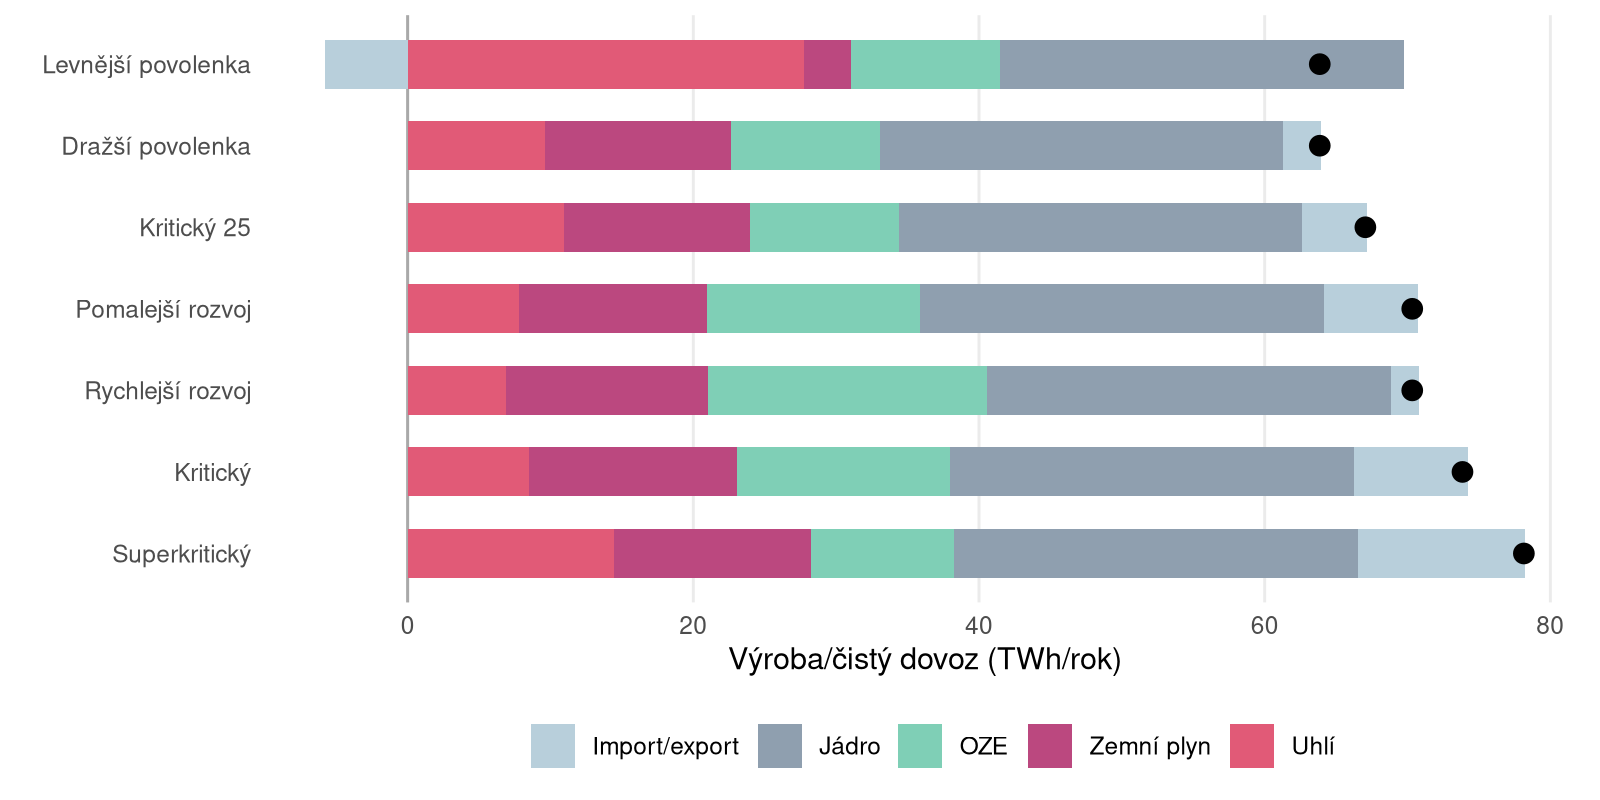

In [51]:
fig_width <- 8
fig_height <- 4
options(repr.plot.width = fig_width, repr.plot.height = fig_height)

df_production |>
  # filter(!str_detect(name, "[Kk]rit")) |>
  ggplot(aes(production_TWh, fct_rev(name))) +
  geom_vline(xintercept = 0, colour = "darkgrey") +
  geom_col(
    aes(fill = fct_relevel(source_group, "NetImport", "Nuclear", "Renewables", "Gas")),
    width = .6
  ) +
  geom_point(
    aes(x = demand_TWh),
    data = df_import_totals |>
      # filter(name != "Superkritický") |>
      filter(region == "CZ", stat == "load_TWh") |>
      select(name, region, demand_TWh = val),
    size = 3,
    fill = "black"
  ) +
  scale_fill_source() +
  labs(
    x = "Výroba/čistý dovoz (TWh/rok)",
    y = ""
  ) +
  theme(
    legend.position = "bottom",
    panel.grid.major.y = element_blank(),
    panel.grid.major.x = element_line()
  )

save_svg_data(save_svgs, df_production, "fig-1-production-by-source", fig_width, fig_height)


## Fig. 3.1+4.1: Coal capacity


In [23]:
df_coal_capacities_short <- df_coal_capacities |>
  mutate(name = fct_expand(name, "Dnešní stav") |> fct_relevel("Dnešní stav")) |>
  add_row(name = factor("Dnešní stav"), coal_chp = 4.004, coal_power = 3.213, .before = 1) |>
  select(name, coal_chp, coal_power)

df_coal_capacities_short


name,coal_chp,coal_power
<fct>,<dbl>,<dbl>
Dnešní stav,4.004,3.213
Dražší povolenka,2.401,0.581
Pomalejší rozvoj,2.077,0.899
Rychlejší rozvoj,1.724,0.581
Levnější povolenka,2.442,1.875


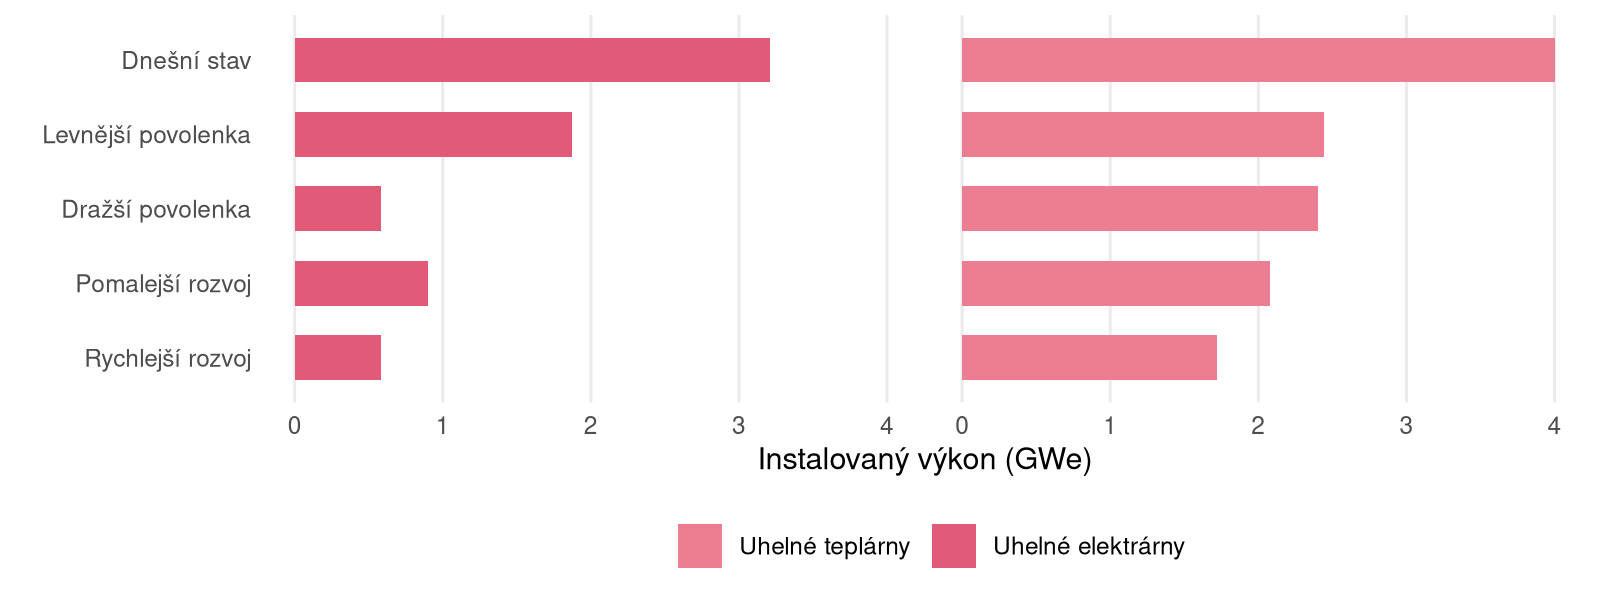

In [52]:
fig_width <- 8
fig_height <- 3
options(repr.plot.width = fig_width, repr.plot.height = fig_height)

df_coal_capacities_short |>
  pivot_longer(!name, names_to = "category", values_to = "capacity") |>
  ggplot(aes(capacity, fct_rev(name))) +
  geom_col(aes(fill = category), width = .6) +
  scale_fill_coal_category() +
  facet_grid(cols = vars(category == "coal_chp")) +
  labs(
    x = "Instalovaný výkon (GWe)",
    y = ""
  ) +
  theme(
    legend.position = "bottom",
    panel.grid.major.y = element_blank(),
    panel.grid.major.x = element_line(),
    strip.text = element_blank()
  )

save_svg_data(save_svgs, df_coal_capacities_short, "fig-3.1-coal-installed-capacity", fig_width, fig_height)


### Subclaim: Enough electricity across weather years


In [25]:
df_all_years_stats |>
  filter(
    name == "Dražší povolenka",
    source %in% c("offshore", "onshore", "solar"),
    stat == "production_TWh"
  ) |>
  summarise(
    val = sum(val),
    .by = c(year, source)
  ) |>
  pivot_wider(names_from = source, values_from = val) |>
  mutate(wind = offshore + onshore) |>
  mutate(across(!year, ~ round(.x)))


year,solar,onshore,offshore,wind
<int>,<dbl>,<dbl>,<dbl>,<dbl>
1985,364,600,191,790
1989,372,611,195,806
2008,368,627,208,836
2009,372,596,192,788
2014,367,598,195,793


In [27]:
df_all_years_stats |>
  filter(
    name == "Dražší povolenka",
    source == "TOTAL",
    stat == "load_TWh"
  ) |>
  summarise(
    total_demand_TWh = sum(val) |> round(),
    .by = year
  )


year,total_demand_TWh
<int>,<dbl>
1985,3469
1989,3383
2008,3404
2009,3428
2014,3367


## Fig. 3.2+4.2: Fossil production


In [32]:
df_production_fossil <- df_all_years_stats |>
  filter(
    region == "CZ",
    stat == "production_TWh",
    str_detect(source, "^coal|^lig|^gas")
  ) |>
  summarise(
    val = mean(val),
    .by = c(name, region, source)
  ) |>
  mutate(
    source_group = case_when(
      str_detect(source, "gas_(eng_)?chp") ~ "gas_chp",
      str_detect(source, "^gas") ~ "gas_power",
      str_detect(source, "_bp$|_ex$") ~ "coal_chp",
      .default = "coal_power"
    )
  ) |>
  summarise(
    production_TWh = sum(val, na.rm = TRUE),
    .by = c(name, region, source_group)
  ) |>
  arrange(name, region, source_group) |>
  mutate(
    source_group = factor(
      source_group,
      levels = c("coal_power", "coal_chp", "gas_power", "gas_chp"),
      labels = c("Uhlí, elektrárny", "Uhlí, teplárny", "Zemní plyn, elektrárny", "Zemní plyn, teplárny")
    )
  )


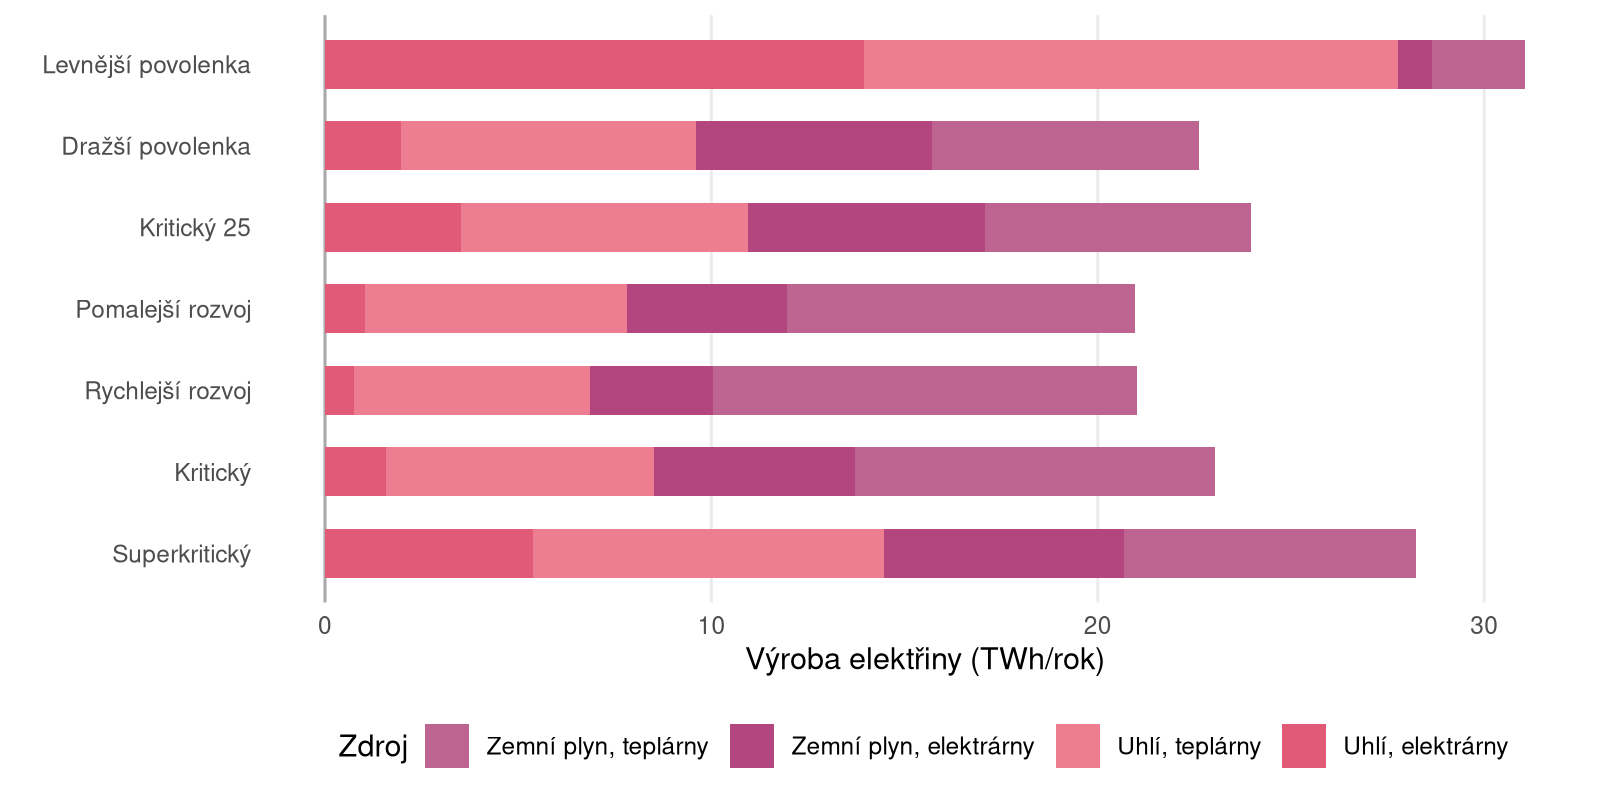

In [53]:
fig_width <- 8
fig_height <- 4
options(repr.plot.width = fig_width, repr.plot.height = fig_height)

df_production_fossil |>
  # filter(name != "Superkritický") |>
  ggplot(aes(production_TWh, fct_rev(name))) +
  geom_vline(xintercept = 0, colour = "darkgrey") +
  geom_col(
    aes(fill = fct_rev(source_group)),
    width = .6
  ) +
  scale_fill_manual(
    "Zdroj",
    values = c("#be6490", "#b3467f", "#ed7e92", "#e15a77")
  ) +
  labs(
    x = "Výroba elektřiny (TWh/rok)",
    y = ""
  ) +
  theme(
    legend.position = "bottom",
    panel.grid.major.y = element_blank(),
    panel.grid.major.x = element_line()
  )

save_svg_data(save_svgs, df_production_fossil, "fig-3.2-fossil-production", fig_width, fig_height)


### Subclaim: LOLE & EENS


In [34]:
df_lole <- df_all_years_stats |>
  filter(
    !str_detect(name, "[Kk]rit"),
    stat %in% c("production_hours", "production_TWh"),
    source == "eens"
  ) |>
  summarise(
    val = mean(val),
    .by = c(name, region, stat)
  ) |>
  pivot_wider(names_from = stat, values_from = val) |>
  transmute(
    name,
    region,
    eens_GWh = round(production_TWh * 1000, 2),
    lole_h = production_hours
  ) |>
  filter(lole_h > 0)

df_lole


name,region,eens_GWh,lole_h
<fct>,<chr>,<dbl>,<dbl>
Levnější povolenka,PL,9.29,10.0
Dražší povolenka,PL,5.51,3.4
Dražší povolenka,LU,1.57,1.6
Dražší povolenka,DE,1.01,0.8
Dražší povolenka,RS,0.01,0.2
Pomalejší rozvoj,LU,1.33,1.4
Pomalejší rozvoj,DE,2.19,0.6
Pomalejší rozvoj,PL,8.76,4.6
Pomalejší rozvoj,FR,1.81,1.0


## Fig. 3.3+4.3: Import/export by neighbour


In [35]:
df_weekly_imports_all <- str_glue("{output_dir}/coaldown+weather-????/*/CZ.csv") |>
  Sys.glob() |>
  map(
    ~ read_csv(.x) |>
      select(Date, starts_with("Import_") | starts_with("Export_")) |>
      group_by(week = isoweek(Date)) |>
      summarise(across(!Date, sum)) |>
      mutate(
        name = str_extract(.x, "(?<=/)[^/]+(?=/\\w+\\.csv)"),
        year = str_extract(.x, "(?<=weather-)[0-9]+"),
        .before = 1
      )
  ) |>
  list_rbind() |>
  # Skip the no-development scenario.
  filter(name != "2028-no") |>
  pivot_longer(
    !name:week,
    names_sep = "_",
    names_to = c("direction", "neighbour"),
    values_to = "value"
  ) |>
  mutate(value = value / 1e6) |>
  pivot_wider(names_from = direction, values_from = value) |>
  fix_scenario_names()

df_weekly_imports_year <- df_weekly_imports_all |>
  filter(year == mainline_weather_year)

df_weekly_imports <- df_weekly_imports_all |>
  summarise(
    Import = mean(Import),
    Export = mean(Export),
    .by = c(name, week, neighbour)
  )


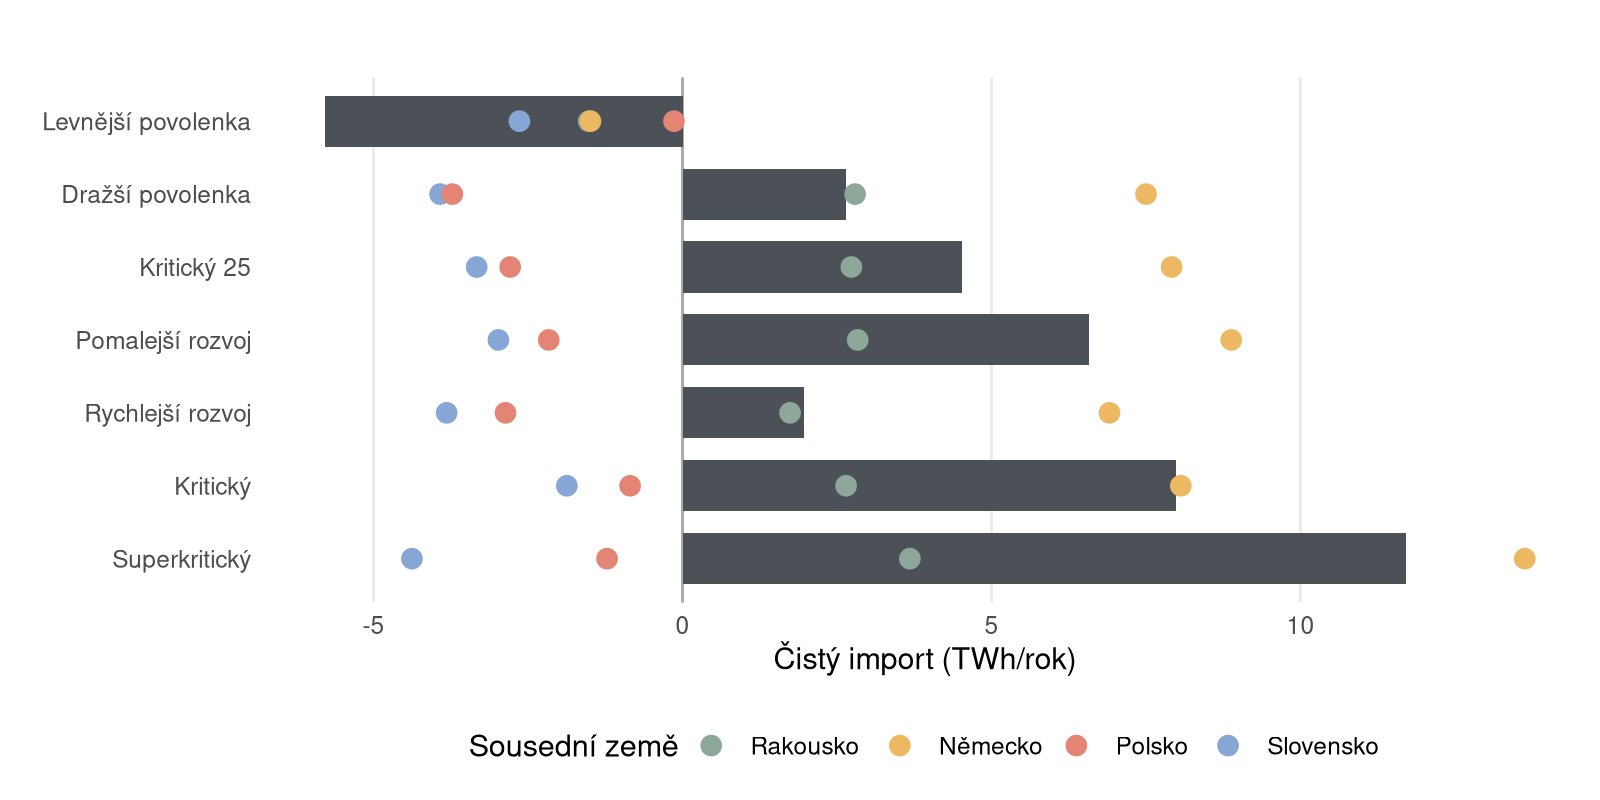

In [45]:
fig_width <- 8
fig_height <- 4
options(repr.plot.width = fig_width, repr.plot.height = fig_height)

df_weekly_imports |>
  summarise(across(Import:Export, sum), .by = c(name, neighbour)) |>
  # filter(!str_detect(name, "[Kk]rit")) |>
  ggplot(aes(x = Import - Export, y = fct_rev(name))) +
  geom_vline(xintercept = 0, colour = "darkgrey") +
  stat_summary(
    aes(group = name),
    fun = sum,
    geom = "col",
    fill = "#4b5156",
    width = .7
  ) +
  geom_point(aes(colour = neighbour), size = 3) +
  scale_colour_region() +
  labs(
    title = "",
    x = "Čistý import (TWh/rok)",
    y = ""
  ) +
  theme(
    legend.position = "bottom",
    panel.grid.major.y = element_blank(),
    panel.grid.major.x = element_line()
  )

save_svg_data(
  save_svgs,
  df_weekly_imports |>
    summarise(across(Import:Export, sum), .by = c(name, neighbour)) |>
    rename(ExportTWh = Export, ImportTWh = Import),
  "fig-3.3-cross-border-balance",
  fig_width,
  fig_height
)


## Fig. 3.3a: Weekly cross-border flows


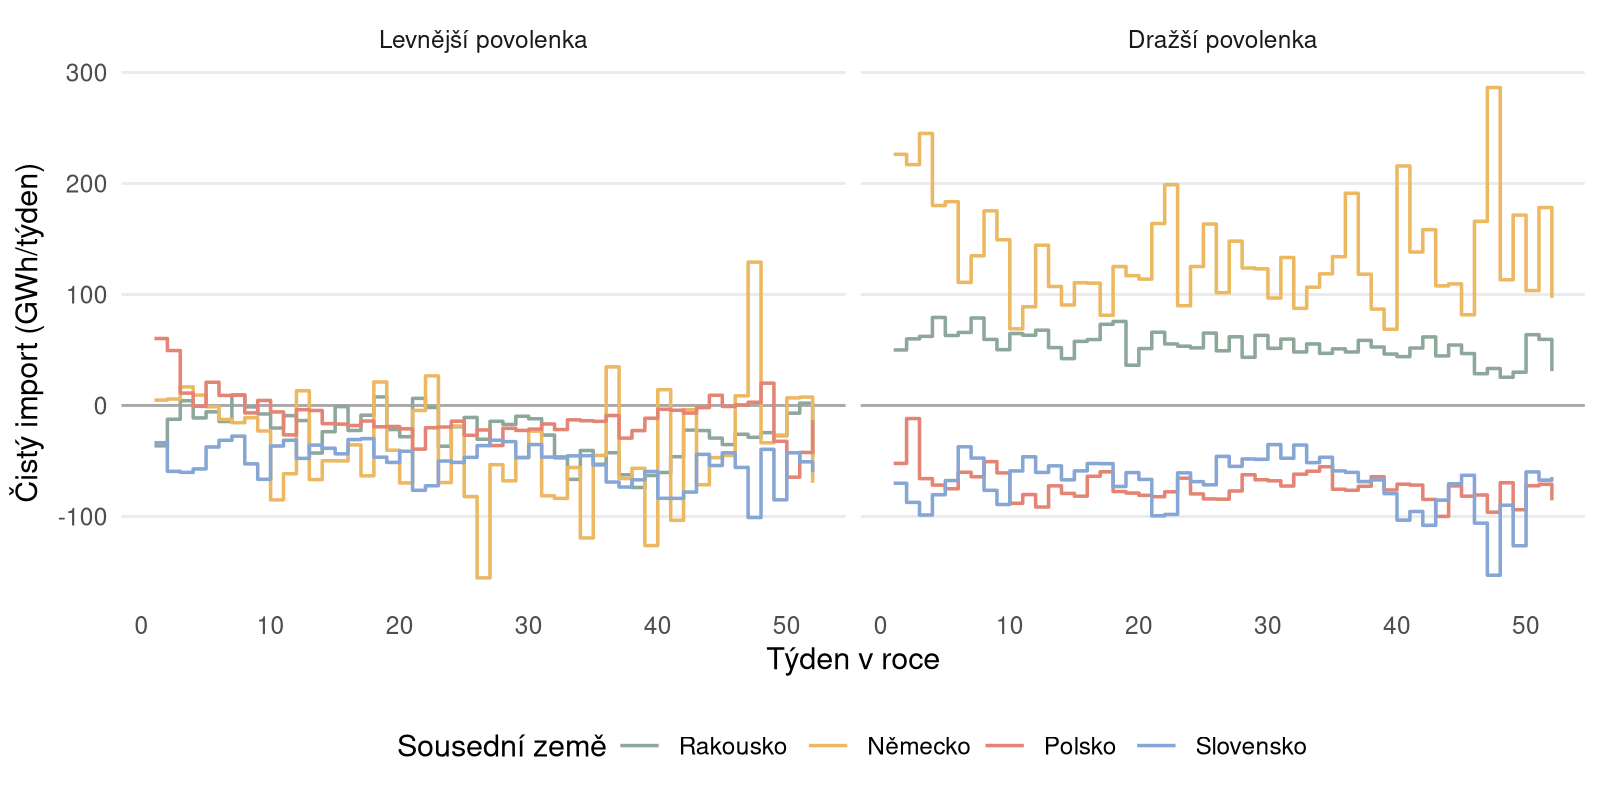

In [46]:
fig_width <- 8
fig_height <- 4
options(repr.plot.width = fig_width, repr.plot.height = fig_height)

df_weekly_imports_year |>
  filter(str_detect(name, "povolenka")) |>
  ggplot(aes(x = week, y = 1000 * (Import - Export))) +
  geom_hline(yintercept = 0, colour = "darkgrey") +
  geom_step(aes(colour = neighbour), linewidth = .6) +
  scale_colour_region() +
  facet_wrap(vars(name)) +
  labs(
    x = "Týden v roce",
    y = "Čistý import (GWh/týden)",
  ) +
  theme(
    legend.position = "bottom"
  )

save_svg_data(
  save_svgs,
  df_weekly_imports_year |>
    rename(ExportTWh = Export, ImportTWh = Import),
  "fig-3.3-cross-border-weekly-flows",
  fig_width,
  fig_height
)


## Fig. 3.3b: Change in net imports


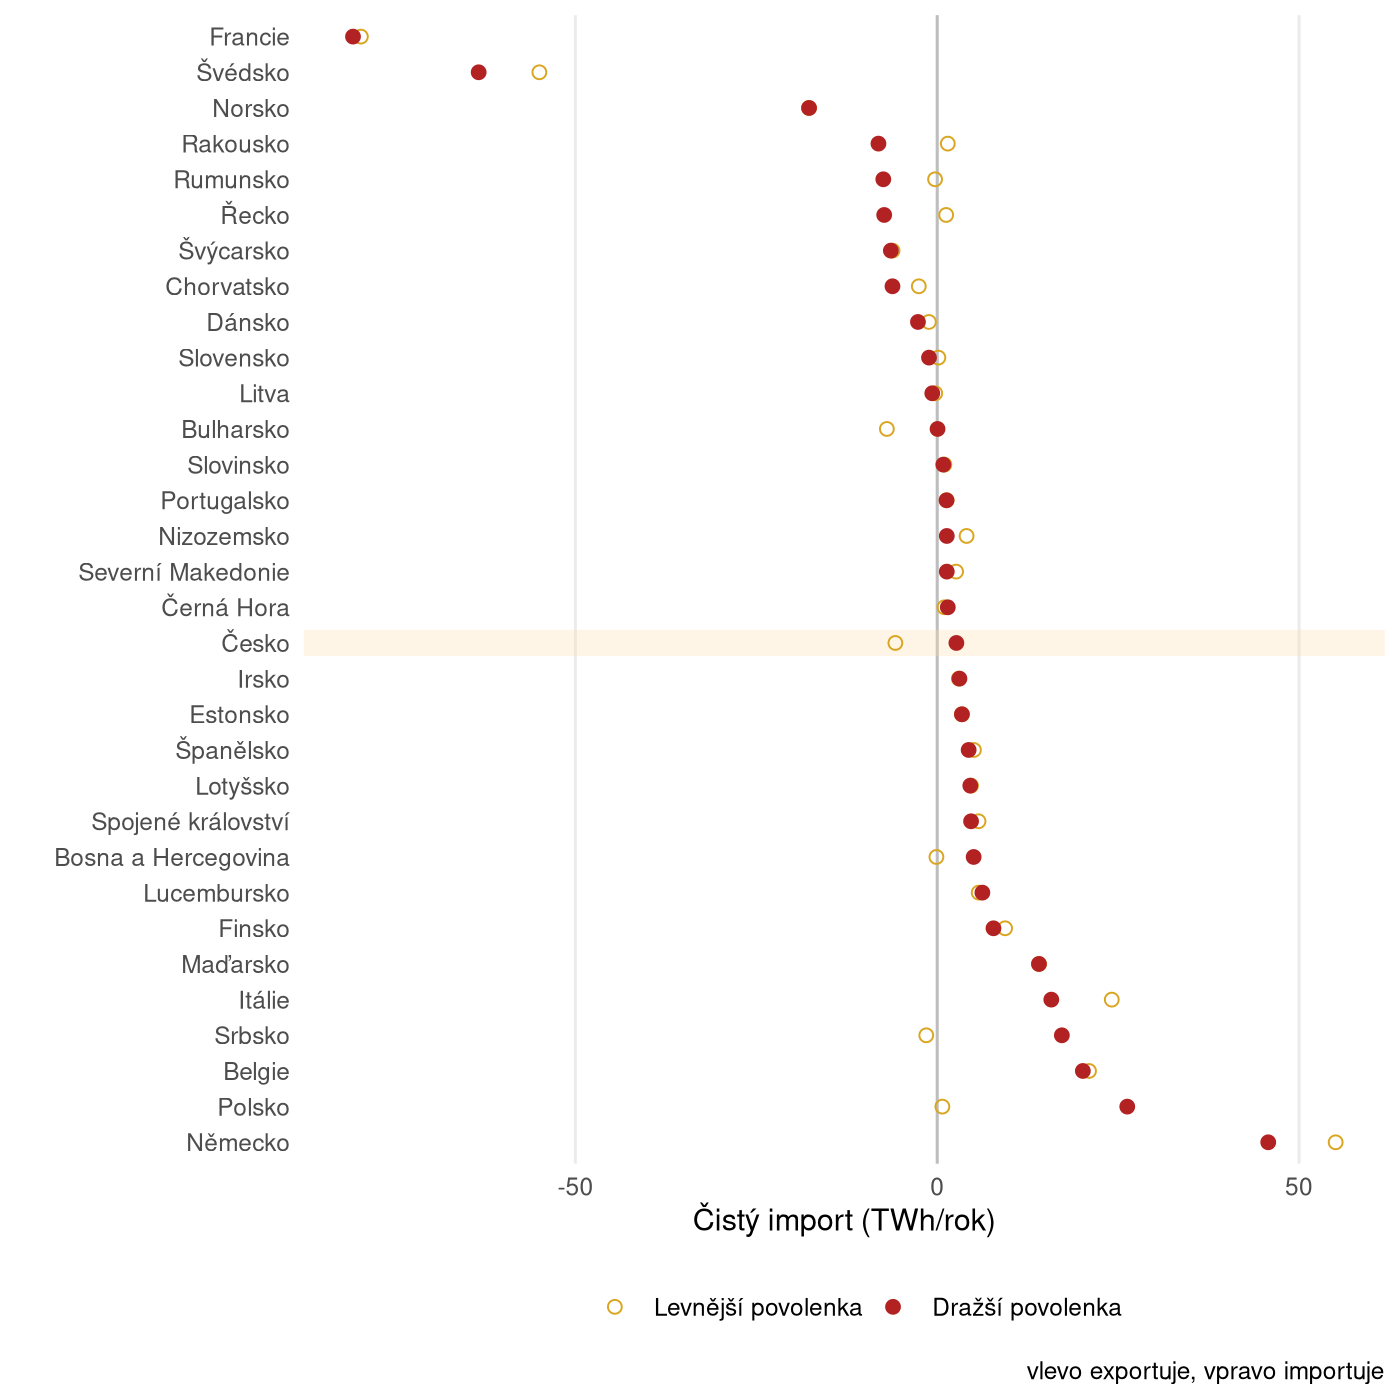

In [40]:
fig_width <- 7
fig_height <- 7
options(repr.plot.width = fig_width, repr.plot.height = fig_height)

df_net_imports_across_europe <- df_import_totals |>
  filter(
    str_detect(name, "povolenka"),
    stat == "net_import_TWh"
  ) |>
  select(name, country_name, net_import_TWh = val) |>
  mutate(
    country_name = fct_reorder2(country_name, name, net_import_TWh, last2)
  )

df_net_imports_across_europe |>
  ggplot(aes(net_import_TWh, country_name)) +
  geom_vline(xintercept = 0, colour = "grey") +
  geom_hline(yintercept = "Česko", linewidth = 4.4, colour = "navajowhite", alpha = .3) +
  geom_point(
    aes(shape = name, colour = name),
    size = 2
  ) +
  scale_colour_manual("", values = c("goldenrod", "firebrick")) +
  scale_shape_manual("", values = c(1, 19)) +
  labs(
    x = "Čistý import (TWh/rok)",
    y = "",
    caption = "vlevo exportuje, vpravo importuje"
  ) +
  theme(
    legend.position = "bottom",
    panel.grid.major.x = element_line(),
    panel.grid.major.y = element_blank()
  )

df_net_imports_across_europe_pivot <- df_net_imports_across_europe |>
  pivot_wider(names_from = name, values_from = net_import_TWh) |>
  mutate(
    swapped = (`Levnější povolenka` / `Dražší povolenka`) < 0
  )

save_svg_data(
  save_svgs,
  df_net_imports_across_europe_pivot,
  "fig-3.3-net-imports-across-europe",
  fig_width,
  fig_height
)


## Fig. 3.4+4.4: Power sector emissions


In [47]:
df_emissions <- df_all_years_stats |>
  filter(
    region == "CZ",
    stat == "emissions_MtCO2" | stat == "production_TWh"
  ) |>
  summarise(
    val = mean(val),
    .by = c(name, stat, source)
  ) |>
  pivot_wider(names_from = stat, values_from = val) |>
  mutate(
    emissions_MtCO2 = case_match(
      source,
      "lig_bp" ~ 1 * .4 / .2 * production_TWh,
      "lig_ex" ~ 1 * production_TWh,
      "coal_bp" ~ .846 * .4 / .2 * production_TWh,
      "coal_ex" ~ .846 * production_TWh,
      "gas_chp" ~ .22 / .56 * production_TWh,
      "gas_eng_chp" ~ .22 / .4 * production_TWh,
      .default = emissions_MtCO2
    ),
    source = case_when(
      str_detect(source, "^coal_(bp|ex)|^lig_(bp|ex)") ~ "Coal CHP",
      str_detect(source, "^coal|^lig") ~ "Coal power",
      str_detect(source, "^gas") ~ "Gas"
    )
  ) |>
  filter(!is.na(source)) |>
  summarise(
    emissions_MtCO2 = sum(emissions_MtCO2),
    .by = c(name, source)
  )

df_emissions |>
  pivot_wider(names_from = source, values_from = emissions_MtCO2) |>
  mutate(
    Total = `Coal CHP` + `Coal power` + Gas,
    across(where(is.numeric), ~ round(.x, 2))
  )


name,Gas,Coal power,Coal CHP,Total
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Superkritický,5.77,5.08,13.62,24.46
Levnější povolenka,1.49,13.66,18.30,33.45
Dražší povolenka,5.41,1.83,12.13,19.37
Pomalejší rozvoj,5.61,0.97,11.28,17.87
Rychlejší rozvoj,6.22,0.69,10.38,17.29
Kritický,6.16,1.49,11.43,19.09
Kritický 25,5.42,3.28,11.95,20.65


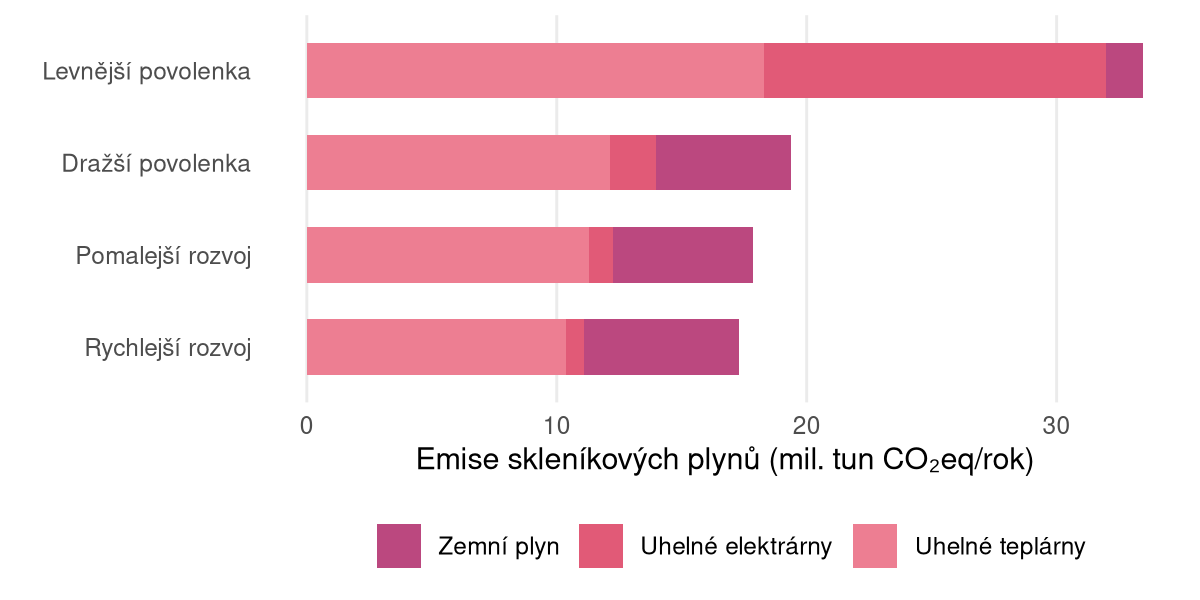

In [54]:
fig_width <- 6
fig_height <- 3
options(repr.plot.width = fig_width, repr.plot.height = fig_height)

df_emissions |>
  filter(!str_detect(name, "[Kk]rit")) |>
  ggplot(aes(emissions_MtCO2, fct_rev(name))) +
  geom_col(aes(fill = fct_rev(source)), width = .6) +
  scale_fill_source() +
  labs(
    x = "Emise skleníkových plynů (mil. tun CO₂eq/rok)",
    y = ""
  ) +
  theme(
    legend.position = "bottom",
    panel.grid.major.y = element_blank(),
    panel.grid.major.x = element_line()
  )

save_svg_data(save_svgs, df_emissions, "fig-3.4-power-ghg-emissions", fig_width, fig_height)


### Subclaim: Total European power sector emissions


In [56]:
df_all_years_stats |>
  filter((stat == "emissions_MtCO2" | stat == "production_TWh") & season == "Y" & source != "TOTAL") |>
  summarise(
    val = mean(val),
    .by = c(name, region, stat, source)
  ) |>
  pivot_wider(names_from = stat, values_from = val) |>
  mutate(
    emissions_MtCO2 = case_match(
      source,
      "lig_bp" ~ 1 * .4 / .2 * production_TWh,
      "lig_ex" ~ 1 * production_TWh,
      "coal_bp" ~ .846 * .4 / .2 * production_TWh,
      "coal_ex" ~ .846 * production_TWh,
      "gas_chp" ~ .22 / .56 * production_TWh,
      "gas_eng_chp" ~ .22 / .4 * production_TWh,
      .default = emissions_MtCO2
    )
  ) |>
  summarise(
    emissions_MtCO2 = sum(emissions_MtCO2) |> round(),
    .by = c(name)
  )


name,emissions_MtCO2
<fct>,<dbl>
Superkritický,494
Levnější povolenka,434
Dražší povolenka,327
Pomalejší rozvoj,243
Rychlejší rozvoj,241
Kritický,265
Kritický 25,345


## Fig. 4.5: Average price comparison


In [58]:
df_prices <- str_glue("{output_dir}/coaldown+weather-????/*/*.csv") |>
  Sys.glob() |>
  map(
    ~ read_csv(.x, show_col_types = FALSE) |>
      select(Date, Load, Price, Price_Type) |>
      mutate(
        name = str_extract(.x, "(?<=/)[^/]+(?=/\\w+\\.csv)"),
        region = str_extract(.x, "\\w+(?=\\.csv)"),
        year = str_extract(.x, "(?<=weather-)[0-9]+") |> as.integer(),
        .before = 1
      )
  ) |>
  list_rbind() |>
  # Skip the no-development scenario.
  filter(name != "2028-no") |>
  fix_scenario_names()


In [59]:
df_weekly_prices <- df_prices |>
  # Select one year
  filter(year == mainline_weather_year) |>
  group_by(
    name,
    region,
    week = isoweek(Date)
  ) |>
  summarise(
    Demand = sum(Load) / 1e6,
    Price = weighted.mean(Price, Load),
    .groups = "drop"
  )

df_annual_prices <- df_prices |>
  summarise(
    Demand = sum(Load) / 1e6,
    Price = weighted.mean(Price, Load),
    .by = c(name, region)
  )


In [66]:
df_annual_prices |>
  filter(
    str_detect(name, "rozvoj"),
    region %in% c("CZ", "DE", "PL")
  ) |>
  select(!Demand) |>
  pivot_wider(names_from = region, values_from = Price) |>
  mutate(
    CZ_DE_Diff = CZ - DE,
    across(where(is.numeric), ~ round(.x, 1))
  )


name,CZ,DE,PL,CZ_DE_Diff
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Rychlejší rozvoj,93.8,84.6,112.4,9.2
Pomalejší rozvoj,100.3,84.7,112.5,15.7


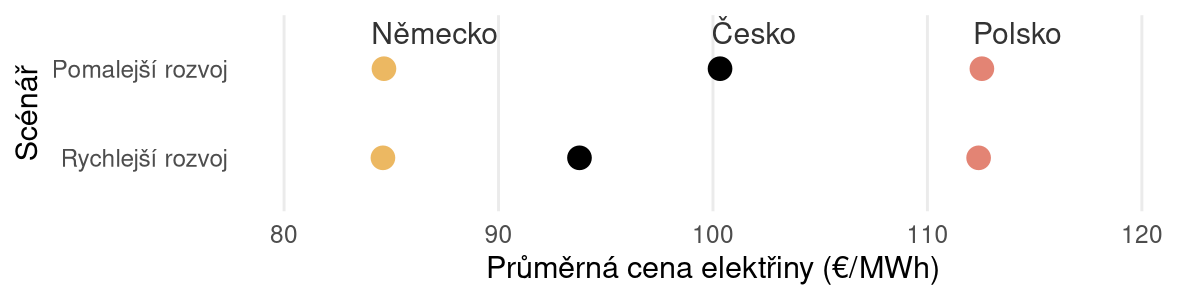

In [69]:
fig_width <- 6
fig_height <- 1.5
options(repr.plot.width = fig_width, repr.plot.height = fig_height)

df_annual_prices |>
  filter(
    str_detect(name, "rozvoj"),
    region %in% c("CZ", "DE", "PL")
  ) |>
  ggplot(aes(Price, fct_rev(name))) +
  geom_point(aes(colour = region), size = 3.5) +
  geom_text(
    aes(label = neighbour_labels[region]),
    data = ~ filter(.x, name == "Pomalejší rozvoj"),
    colour = "grey20",
    size = 3.8,
    nudge_y = .4,
    hjust = .1
  ) +
  scale_colour_region(guide = "none") +
  xlim(80, 120) +
  labs(
    x = "Průměrná cena elektřiny (€/MWh)",
    y = "Scénář"
  ) +
  theme(
    legend.position = "bottom",
    panel.grid.major.x = element_line(),
    panel.grid.major.y = element_blank()
  )

save_svg_data(
  save_svgs,
  filter(df_annual_prices, region %in% c("CZ", "DE", "PL")),
  "fig-4.5-average-annual-prices",
  fig_width,
  fig_height
)


## Fig. 4.5: Weekly price comparison


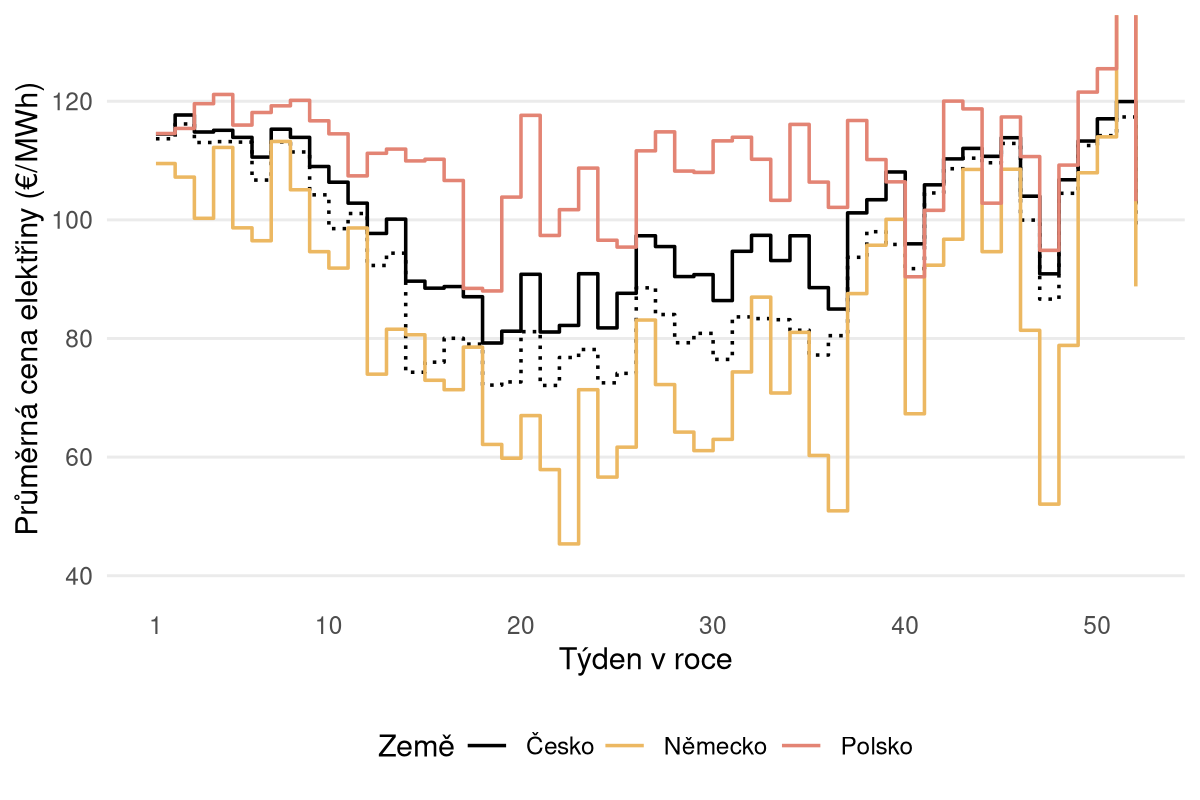

In [74]:
fig_width <- 6
fig_height <- 4
options(repr.plot.width = fig_width, repr.plot.height = fig_height)

df_weekly_prices_for_plot <- df_weekly_prices |>
  filter(
    (region == "CZ" & str_detect(name, "rozvoj")) |
      (region %in% c("DE", "PL") & name == "Pomalejší rozvoj")
  )

df_weekly_prices_for_plot |>
  ggplot(aes(week, Price)) +
  geom_step(
    aes(colour = region, linetype = name),
    linewidth = .6
  ) +
  scale_x_continuous(
    "Týden v roce",
    breaks = c(1, seq(10, 50, 10))
  ) +
  scale_y_continuous("Průměrná cena elektřiny (€/MWh)") +
  scale_colour_region(name = "Země") +
  scale_linetype_manual(guide = "none", values = c("solid", "12")) +
  coord_cartesian(ylim = c(40, 130)) +
  theme(legend.position = "bottom")

save_svg_data(save_svgs, df_weekly_prices_for_plot, "fig-4.5-average-weekly-prices", fig_width, fig_height)


## Fig. 5.3: Coal subsidy analysis


In [81]:
subsidy_analysis_name <- str_glue("coaldown+weather-{subsidy_weather_year}+subsidy")

df_subsidy <- str_glue("{output_dir}/{subsidy_analysis_name}/{subsidy_analysis_name}.csv") |>
  read_csv() |>
  filter(
    region == "CZ",
    (source == "TOTAL" & stat == "net_import_TWh") |
      (str_detect(source, "^lig|^coal") & stat == "production_TWh")
  ) |>
  summarise(
    val = sum(val),
    .by = c(name, stat)
  ) |>
  pivot_wider(names_from = stat, values_from = val) |>
  transmute(
    subsidy_eur_per_MWh = str_extract(name, "(?<=subsidy-)[\\d.]+") |> as.numeric(),
    net_import_TWh = net_import_TWh,
    coal_production_TWh = production_TWh,
    total_subsidy_mn_EUR = subsidy_eur_per_MWh * coal_production_TWh,
    total_subsidy_bn_CZK = total_subsidy_mn_EUR * 25 / 1000
  ) |>
  arrange(subsidy_eur_per_MWh)

df_subsidy |>
  mutate(across(where(is.numeric), ~ round(.x, 2)))


New names:
• `` -> `...1`


subsidy_eur_per_MWh,net_import_TWh,coal_production_TWh,total_subsidy_mn_EUR,total_subsidy_bn_CZK
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.0,11.73,17.37,0.00,0.00
2.5,9.91,19.80,49.49,1.24
5.0,7.20,24.15,120.74,3.02
7.5,4.17,29.97,224.80,5.62
10.0,1.30,34.26,342.60,8.57
12.5,-1.26,40.34,504.28,12.61
15.0,-5.31,47.47,712.01,17.80
17.5,-10.16,53.06,928.59,23.21
20.0,-14.45,57.82,1156.45,28.91


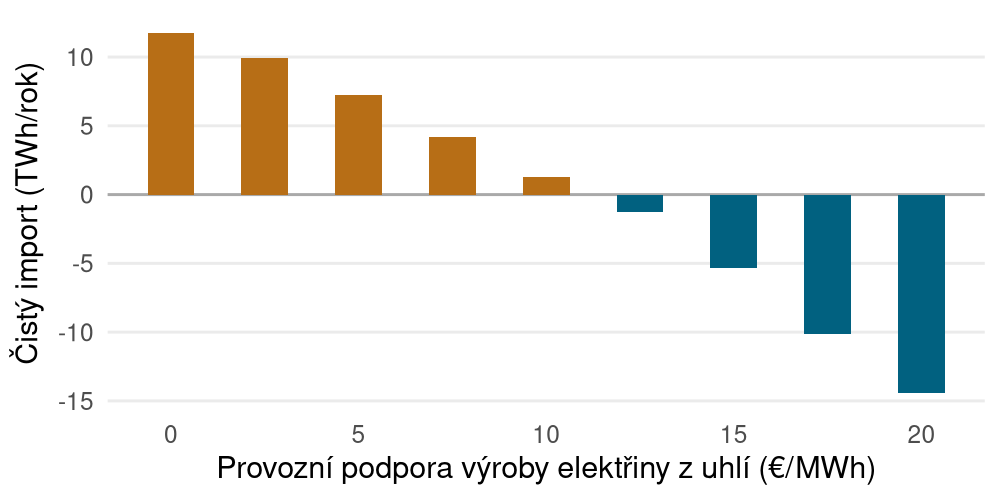

In [92]:
fig_width <- 5
fig_height <- 2.5
options(repr.plot.width = fig_width, repr.plot.height = fig_height)

df_subsidy |>
  ggplot(aes(subsidy_eur_per_MWh, net_import_TWh)) +
  geom_hline(yintercept = 0, colour = "darkgrey") +
  geom_col(aes(fill = net_import_TWh > 0), width = 1.25) +
  scale_fill_manual(
    values = c("#016180", "#b76e16"),
    guide = "none"
  ) +
  labs(
    x = "Provozní podpora výroby elektřiny z uhlí (€/MWh)",
    y = "Čistý import (TWh/rok)"
  )

save_svg_data(save_svgs, df_subsidy, "fig-5.1-coal-subsidy", fig_width, fig_height)


## Annex: Electricity mixes across Europe


In [93]:
df_production_all_countries <- df_all_years_stats |>
  filter(
    stat %in% c("discharging_TWh", "production_TWh"),
    !(source %in% c("TOTAL", "dsr", "eens", "heat", "li", "pump"))
  ) |>
  summarise(
    val = mean(val),
    .by = c(name, region, source)
  ) |>
  mutate(
    source_group = case_when(
      str_detect(source, "^coal|^lig") ~ "Coal",
      str_detect(source, "^gas|^oil") ~ "Gas",
      str_detect(source, "^b_|bio|^h_|(off|on)shore|solar|pump_open") ~ "Renewables",
      source == "nuclear" ~ "Nuclear",
      .default = "Other"
    )
  ) |>
  summarise(
    production_TWh = sum(val, na.rm = TRUE),
    .by = c(name, region, source_group)
  ) |>
  bind_rows(
    df_import_totals |>
      filter(stat == "net_import_TWh") |>
      mutate(source_group = "NetImport") |>
      select(name, region, source_group, production_TWh = val)
  ) |>
  arrange(name, region, source_group) |>
  mutate(
    source_group = fct_relevel(
      source_group,
      "Nuclear",
      "Renewables",
      "Coal",
      "Gas",
      "NetImport"
    ),
    country_name = countrycode::countrycode(region, origin = "iso2c", destination = "cldr.name.cs")
  )


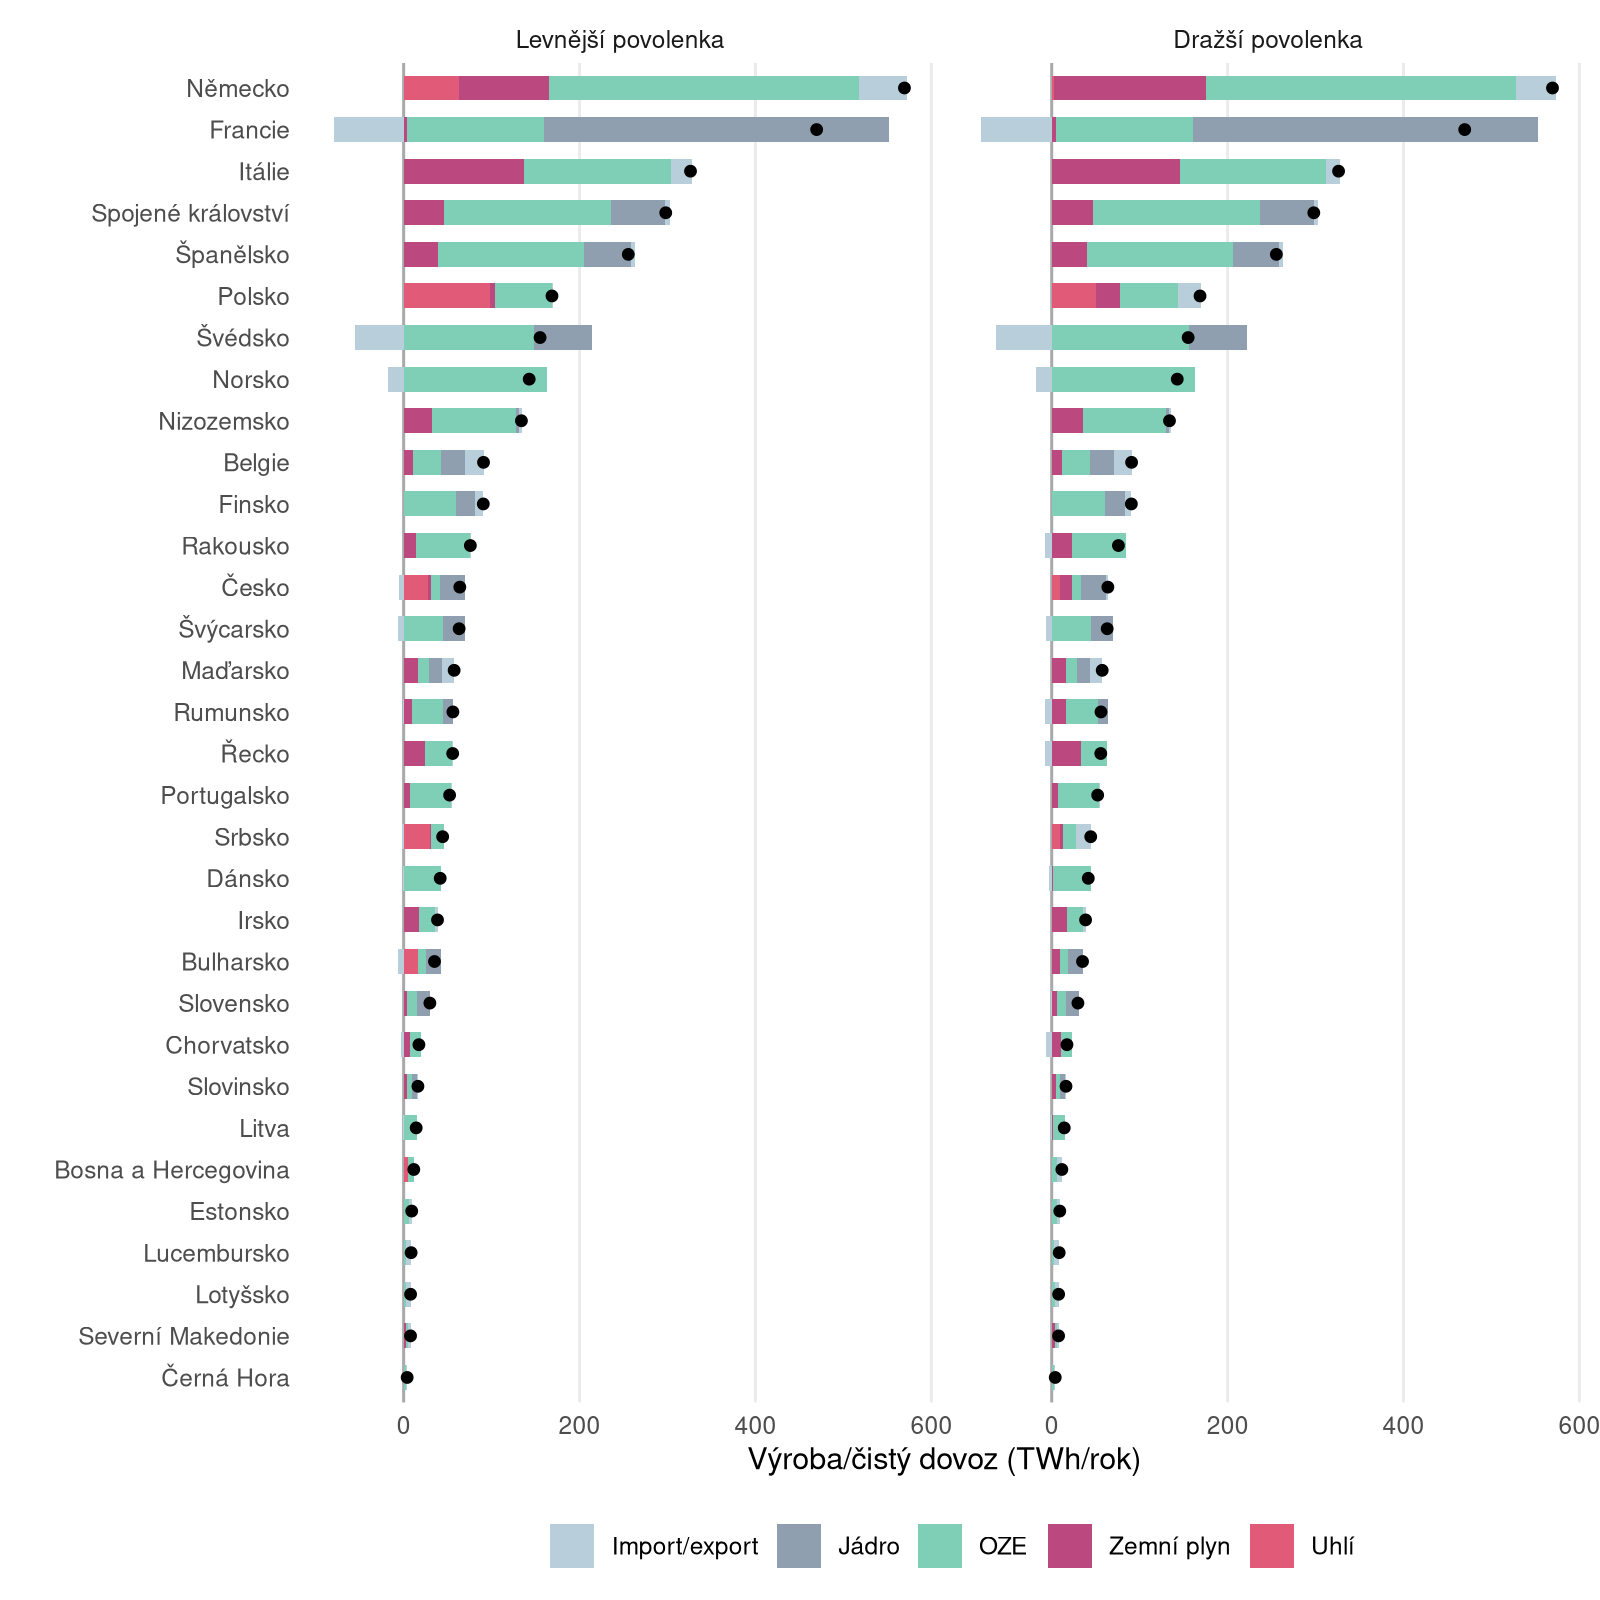

In [94]:
fig_width <- 8
fig_height <- 8
options(repr.plot.width = fig_width, repr.plot.height = fig_height)

df_production_all_countries |>
  filter(str_detect(name, "povolenka")) |>
  mutate(
    country_name = fct_reorder(country_name, production_TWh, sum)
  ) |>
  ggplot(aes(production_TWh, country_name)) +
  geom_vline(xintercept = 0, colour = "darkgrey") +
  geom_col(
    aes(fill = fct_relevel(source_group, "NetImport", "Nuclear", "Renewables", "Gas")),
    width = .6
  ) +
  geom_point(
    aes(x = demand_TWh),
    data = df_import_totals |>
      filter(
        str_detect(name, "povolenka"),
        stat == "load_TWh"
      ) |>
      select(name, region, country_name, demand_TWh = val),
    size = 1.5,
    fill = "black"
  ) +
  scale_fill_source() +
  facet_grid(cols = vars(name)) +
  labs(
    x = "Výroba/čistý dovoz (TWh/rok)",
    y = ""
  ) +
  theme(
    legend.position = "bottom",
    panel.grid.major.y = element_blank(),
    panel.grid.major.x = element_line()
  )


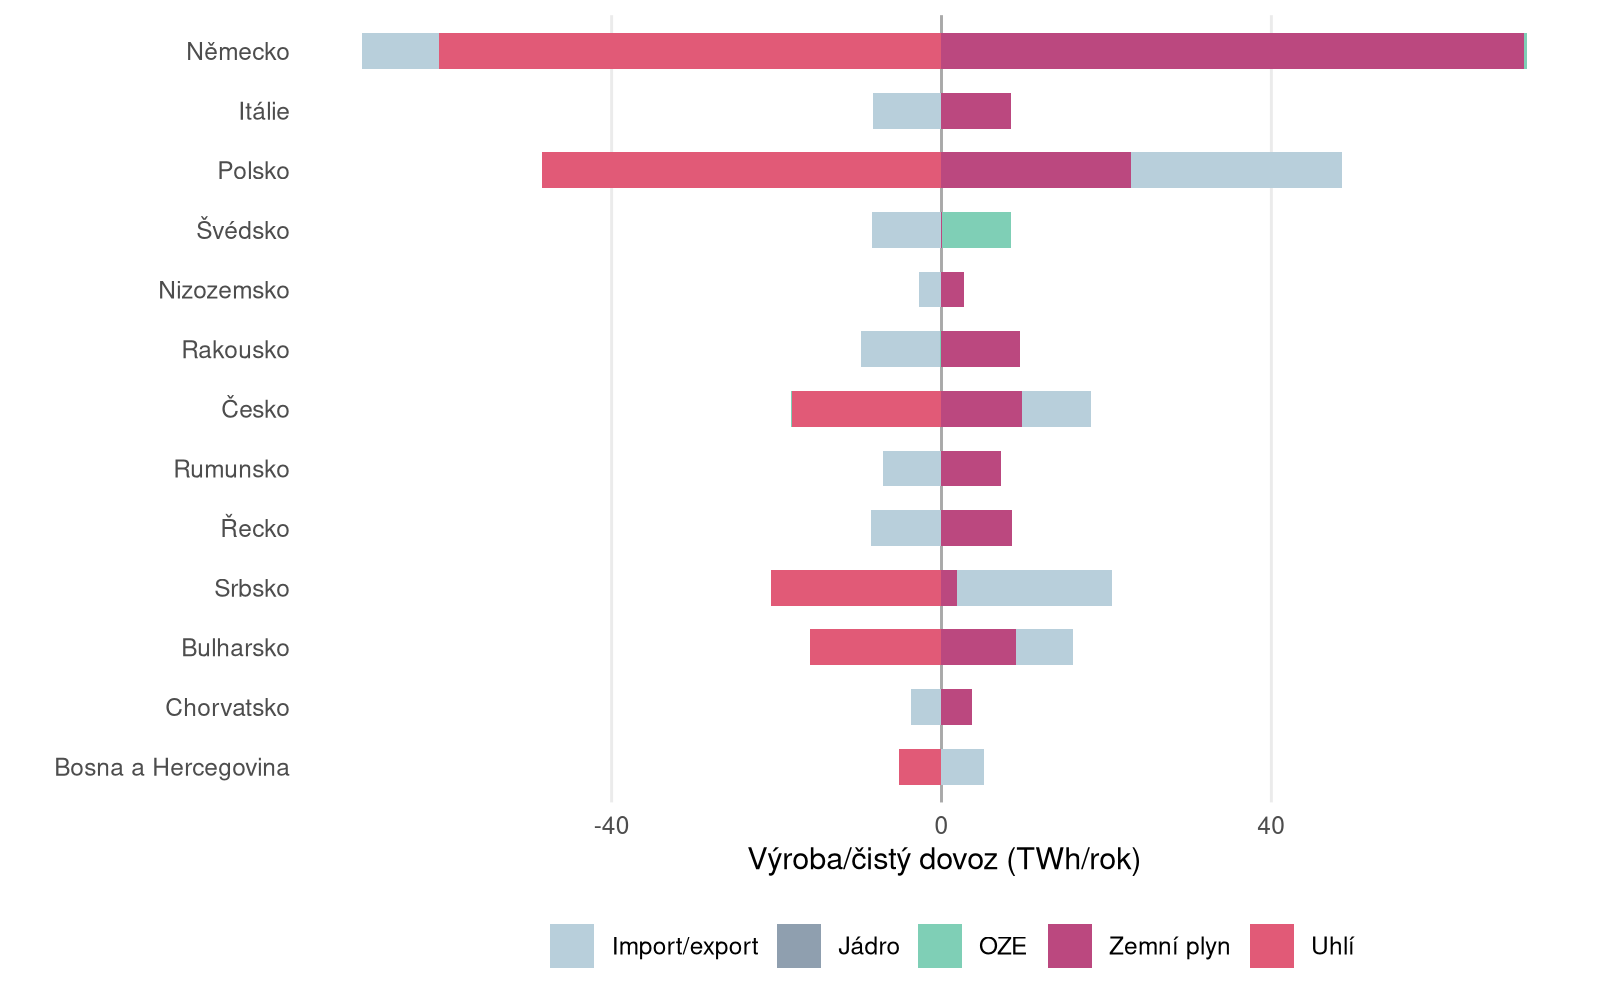

In [95]:
fig_width <- 8
fig_height <- 5
options(repr.plot.width = fig_width, repr.plot.height = fig_height)

df_production_all_countries |>
  filter(str_detect(name, "povolenka")) |>
  mutate(
    country_name = fct_reorder(country_name, production_TWh, sum)
  ) |>
  pivot_wider(names_from = name, values_from = production_TWh) |>
  transmute(source_group, country_name, Diff = `Dražší povolenka` - `Levnější povolenka`) |>
  group_by(country_name) |>
  filter(sum(abs(Diff)) > 5) |>
  ggplot(aes(Diff, country_name)) +
  geom_vline(xintercept = 0, colour = "darkgrey") +
  geom_col(
    aes(fill = fct_relevel(source_group, "NetImport", "Nuclear", "Renewables", "Gas")),
    width = .6
  ) +
  scale_fill_source() +
  labs(
    x = "Výroba/čistý dovoz (TWh/rok)",
    y = ""
  ) +
  theme(
    legend.position = "bottom",
    panel.grid.major.y = element_blank(),
    panel.grid.major.x = element_line()
  )


## Annex: Critical scenarios


In [96]:
df_critical_scenarios <- filter(df_all_years_stats, str_detect(name, "[Kk]rit"))


In [97]:
df_critical_scenarios |>
  filter(
    stat %in% c("production_hours", "production_TWh"),
    source == "eens"
  ) |>
  summarise(
    val = mean(val),
    .by = c(name, region, stat)
  ) |>
  pivot_wider(names_from = stat, values_from = val) |>
  transmute(
    name,
    region,
    eens_GWh = round(production_TWh * 1000, 2),
    lole_h = production_hours
  ) |>
  filter(lole_h > 0) |>
  arrange(name, desc(lole_h))


name,region,eens_GWh,lole_h
<fct>,<chr>,<dbl>,<dbl>
Kritický 25,PL,63.32,49.8
Kritický 25,RS,0.44,3.4
Kritický 25,FR,1.82,1.0
Kritický,RS,5.78,27.4
Kritický,PL,16.48,8.6
Kritický,LU,6.64,7.6
Kritický,DE,27.91,5.2
Kritický,FR,9.95,2.8
Kritický,DK,0.98,1.6


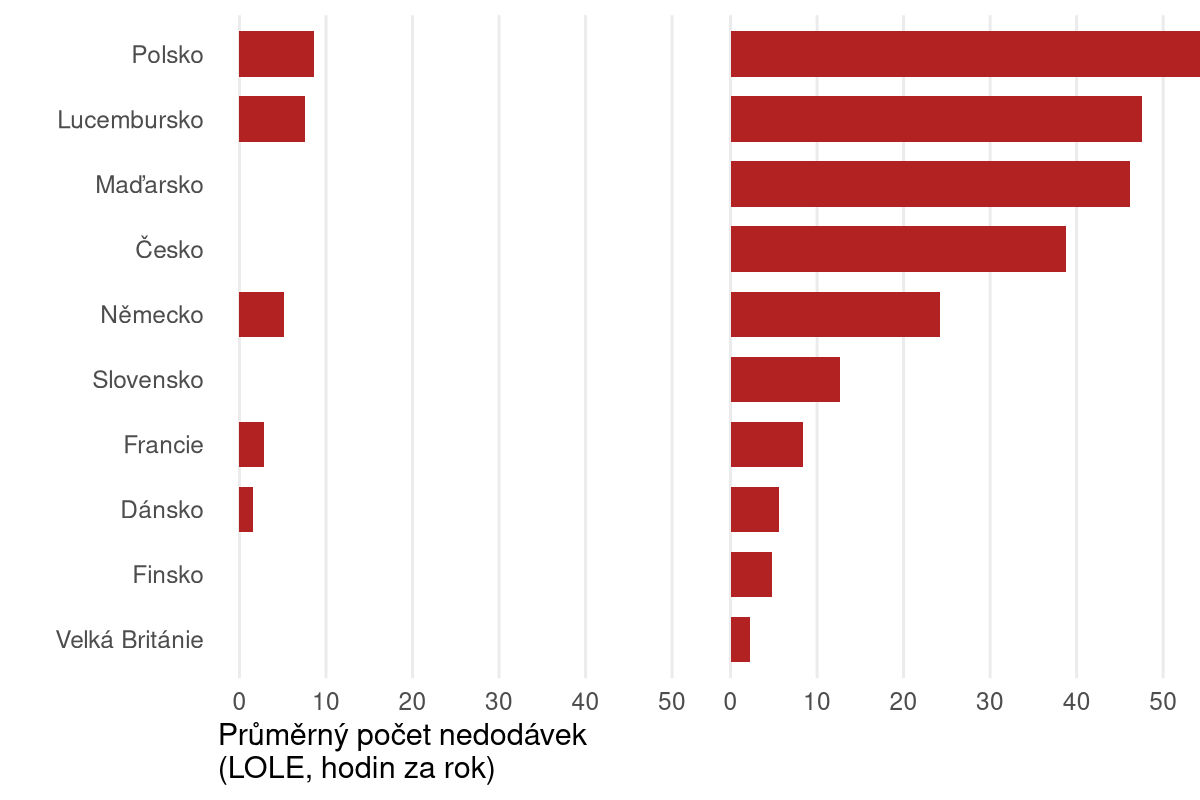

In [100]:
fig_width <- 6
fig_height <- 4
options(repr.plot.width = fig_width, repr.plot.height = fig_height)

df_critical_scenarios |>
  filter(
    !str_detect(name, "25"),
    stat == "production_hours",
    source == "eens"
  ) |>
  summarise(
    val = mean(val),
    .by = c(name, region, stat)
  ) |>
  pivot_wider(names_from = stat, values_from = val) |>
  transmute(
    name,
    region,
    lole_h = production_hours,
    country_name = region |>
      countrycode::countrycode(origin = "iso2c", destination = "cldr.name.cs", custom_match = c("GB" = "Velká Británie")) |>
      fct_reorder(lole_h, max),
  ) |>
  filter(
    lole_h >= 1,
    # The results are not reliable for Serbia.
    region != "RS"
  ) |>
  ggplot(aes(lole_h, country_name)) +
  geom_col(
    fill = "firebrick",
    width = .7
  ) +
  coord_cartesian(xlim = c(0, 50), clip = "off") +
  facet_wrap(vars(name)) +
  labs(
    x = "Průměrný počet nedodávek \n(LOLE, hodin za rok)",
    y = ""
  ) +
  theme(
    axis.title.x = element_text(hjust = 0),
    panel.grid.major.x = element_line(),
    panel.grid.major.y = element_blank(),
    strip.text = element_blank()
  )


## Annex: Peak load intervals


In [101]:
df_load_all_years <- str_glue("{output_dir}/coaldown+weather-????/*/CZ.csv") |>
  Sys.glob() |>
  map(
    ~ read_csv(.x) |>
      select(Date, Load) |>
      mutate(
        name = str_extract(.x, "(?<=/)[^/]+(?=/\\w+\\.csv)"),
        year = str_extract(.x, "(?<=weather-)[0-9]+"),
        .before = 1
      )
  ) |>
  list_rbind() |>
  fix_scenario_names()


In [102]:
# Approx. 9,660 MW is the available dispatchable capacity
# in the 2025 scenarios.
peak_load_threshold_mw <- 9660

df_peaks <- df_load_all_years |>
  filter(name == "Dražší povolenka") |>
  mutate(PeakLoad = Load >= peak_load_threshold_mw) |>
  filter(PeakLoad) |>
  group_by(year) |>
  mutate(
    DateDiff = c(1, diff(Date)),
    Group = cumsum(DateDiff > 1)
  ) |>
  group_by(Group, .add = TRUE) |>
  summarise(
    StartDate = min(Date),
    NumHours = n(),
    ExtraGWh = sum(Load - peak_load_threshold_mw) / 1000,
    MaxLoadMW = max(Load),
    .groups = "drop"
  )

df_peaks |> slice_max(NumHours, n = 5)

df_peaks |> slice_max(NumHours, n = 10)


year,Group,StartDate,NumHours,ExtraGWh,MaxLoadMW
<chr>,<int>,<dttm>,<int>,<dbl>,<dbl>
1985,6,2018-01-11 06:00:00,14,8.151508,10498.70
1985,11,2018-01-18 06:00:00,14,5.687072,10233.74
1985,17,2018-02-13 06:00:00,14,6.415160,10325.96
1985,18,2018-02-14 06:00:00,14,7.829945,10404.90
1985,19,2018-02-15 06:00:00,14,7.369087,10396.69
2009,6,2018-01-11 06:00:00,14,6.914689,10344.92
2009,7,2018-01-12 06:00:00,14,8.599093,10477.28


year,Group,StartDate,NumHours,ExtraGWh,MaxLoadMW
<chr>,<int>,<dttm>,<int>,<dbl>,<dbl>
1985,6,2018-01-11 06:00:00,14,8.151508,10498.70
1985,11,2018-01-18 06:00:00,14,5.687072,10233.74
1985,17,2018-02-13 06:00:00,14,6.415160,10325.96
1985,18,2018-02-14 06:00:00,14,7.829945,10404.90
1985,19,2018-02-15 06:00:00,14,7.369087,10396.69
2009,6,2018-01-11 06:00:00,14,6.914689,10344.92
2009,7,2018-01-12 06:00:00,14,8.599093,10477.28
1985,1,2018-01-04 07:00:00,13,6.195314,10296.56
1985,2,2018-01-05 07:00:00,13,7.637000,10439.44
